In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from PIL import Image
from pathlib import Path
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
train_data_path = Path('./data/train/simpsons_dataset/')
test_data_path = Path('./data/testset/')

train_file = sorted(list(train_data_path.rglob('*.jpg')))
test_file = sorted(list(test_data_path.rglob('*.jpg')))

train_labels_name = [path.parent.name for path in train_file]

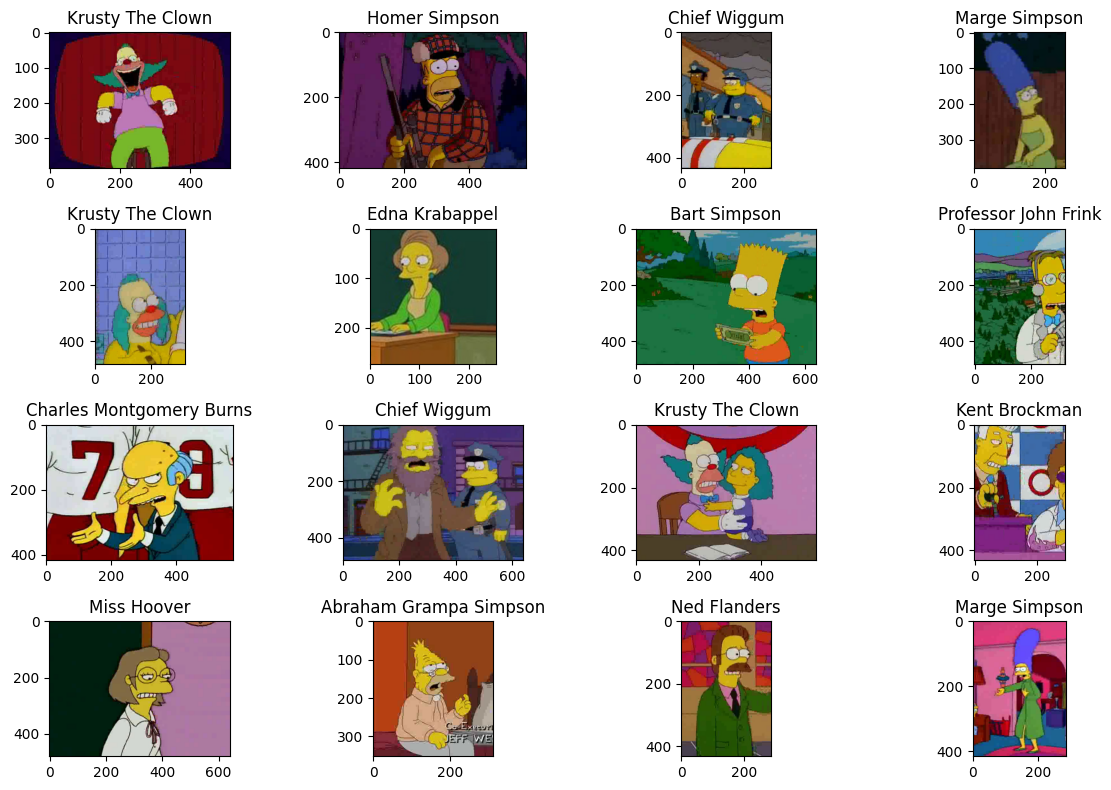

In [4]:
num = len(train_labels_name)

fig, axes = plt.subplots(4, 4)
fig.set_size_inches((12, 8))
for ax in axes.flatten():
    n = np.random.randint(num)
    ax.imshow(Image.open(train_file[n])) #plt.imread
    ax.set_title(train_labels_name[n].replace('_', ' ').title())
plt.tight_layout()

In [5]:
transform = {'train': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
             'test': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])}

full_train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform['train'])
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform['test'])

train_dataloader = DataLoader(train_dataset, shuffle=True, 
                              num_workers=4, batch_size=32)
val_dataloader = DataLoader(val_dataset, shuffle=True, 
                              num_workers=4, batch_size=32)
test_dataloader = DataLoader(test_dataset, shuffle=False, 
                              num_workers=4, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3088455]

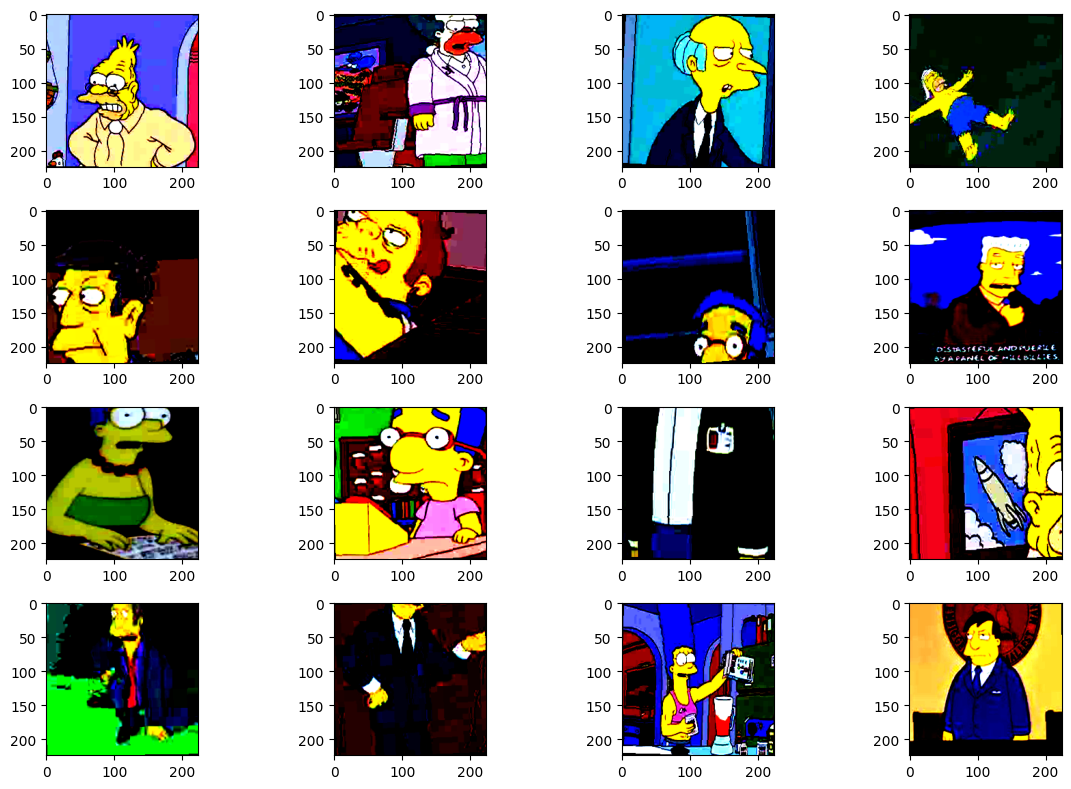

In [6]:
num = len(train_dataset)
fig, axes = plt.subplots(4, 4)
fig.set_size_inches(12, 8)
for ax in axes.flatten():
    n = np.random.randint(num)
    ax.imshow(train_dataset[n][0].permute(1,2,0).numpy())
plt.tight_layout()

In [7]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96)
        )

        self.fc1 = nn.Linear(96 * 5 * 5, n_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [8]:
def fit(epochs, model, loss_func, opt, sheduler, train_dl, valid_dl):
    train_losses = []
    val_losses = []
    valid_accuracies = []
    valid_f1_scores = []
    for epoch in tqdm(range(epochs)):
        model.train()
        loss_sum = 0
        for xb, yb in tqdm(train_dl):
            xb, yb = xb.to(device), yb.to(device)

            loss = loss_func(model(xb), yb)
            loss_sum += loss.item()

            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_sum / len(train_dl))

        model.eval()
        loss_sum_val = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for xb, yb in tqdm(valid_dl):
                xb, yb = xb.to(device), yb.to(device)

                probs = model(xb)
                loss_sum_val += loss_func(probs, yb).item()
                preds = torch.argmax(probs, dim=1)
                correct += (preds == yb).sum().item()
                total += len(xb) #yb.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())

        val_losses.append(loss_sum_val / len(valid_dl))
        valid_accuracies.append(correct / total)
        #valid_f1_scores.append(f1_score(all_preds, all_labels))
        print(f'epoch {epoch}: accuracy_train: {loss_sum / len(train_dl)}')
        print(f'_______________accuracy_val: {loss_sum_val / len(valid_dl)}')
        print(f'_______________valid_f1_scores: {f1_score(all_preds, all_labels, average='weighted')}')
        sheduler.step()
    return train_losses, val_losses, valid_accuracies

In [9]:
def plot_training(train_losses, val_losses, valid_accuracies):
    fig, ax = plt.subplots(2, 1, figsize=(12, 9))  #2 строки, 1 столбец
    
    ax[0].plot(train_losses, label='train_loss')
    ax[0].plot(val_losses, label='val_loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend()
    
    ax[1].plot(valid_accuracies, label='valid_accuracy')
    ax[1].set_xlabel('epoch')
    ax[1].legend()
    
    plt.tight_layout() 

In [10]:
classes = len(np.unique(train_labels_name))

In [11]:
model = models.resnet50(weights='DEFAULT').to(device)
model.fc = nn.Linear(2048, 42).to(device)
#model.requires_grad_(False)
#model.fc.requires_grad_(True)
#for param in model.parameters():
#    param.requires_grad = False
#for param in model.fc.parameters():
#    param.requires_grad = True

In [12]:
#model = SimpleCnn(classes)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [13]:
info = fit(10, model, criterion, optimizer, scheduler, train_dataloader, val_dataloader) #0.44, 0.51

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/524 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

epoch 0: accuracy_train: 2.404141363751797
_______________accuracy_val: 1.94649063539869
_______________valid_f1_scores: 0.5514047603381181


  0%|          | 0/524 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

epoch 1: accuracy_train: 1.7923497821538503
_______________accuracy_val: 1.6014087737061595
_______________valid_f1_scores: 0.6209294009476988


  0%|          | 0/524 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

epoch 2: accuracy_train: 1.5558065053160863
_______________accuracy_val: 1.4651148919840806
_______________valid_f1_scores: 0.6425971149782019


  0%|          | 0/524 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

epoch 3: accuracy_train: 1.4387057805789336
_______________accuracy_val: 1.4002774767293276
_______________valid_f1_scores: 0.6459489677360812


  0%|          | 0/524 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

epoch 4: accuracy_train: 1.3539362969516797
_______________accuracy_val: 1.330922009380719
_______________valid_f1_scores: 0.6769652492083302


  0%|          | 0/524 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

epoch 5: accuracy_train: 1.2807154838592951
_______________accuracy_val: 1.2992715635372483
_______________valid_f1_scores: 0.6757101993520965


  0%|          | 0/524 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

epoch 6: accuracy_train: 1.2749565468944666
_______________accuracy_val: 1.2988018789364182
_______________valid_f1_scores: 0.6734083097456897


  0%|          | 0/524 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

epoch 7: accuracy_train: 1.247348882997309
_______________accuracy_val: 1.3017016740245673
_______________valid_f1_scores: 0.6848474782903148


  0%|          | 0/524 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

epoch 8: accuracy_train: 1.266594962309335
_______________accuracy_val: 1.2834356568241847
_______________valid_f1_scores: 0.6781254106236158


  0%|          | 0/524 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

epoch 9: accuracy_train: 1.255535303408863
_______________accuracy_val: 1.2779314845572902
_______________valid_f1_scores: 0.6768854737295193


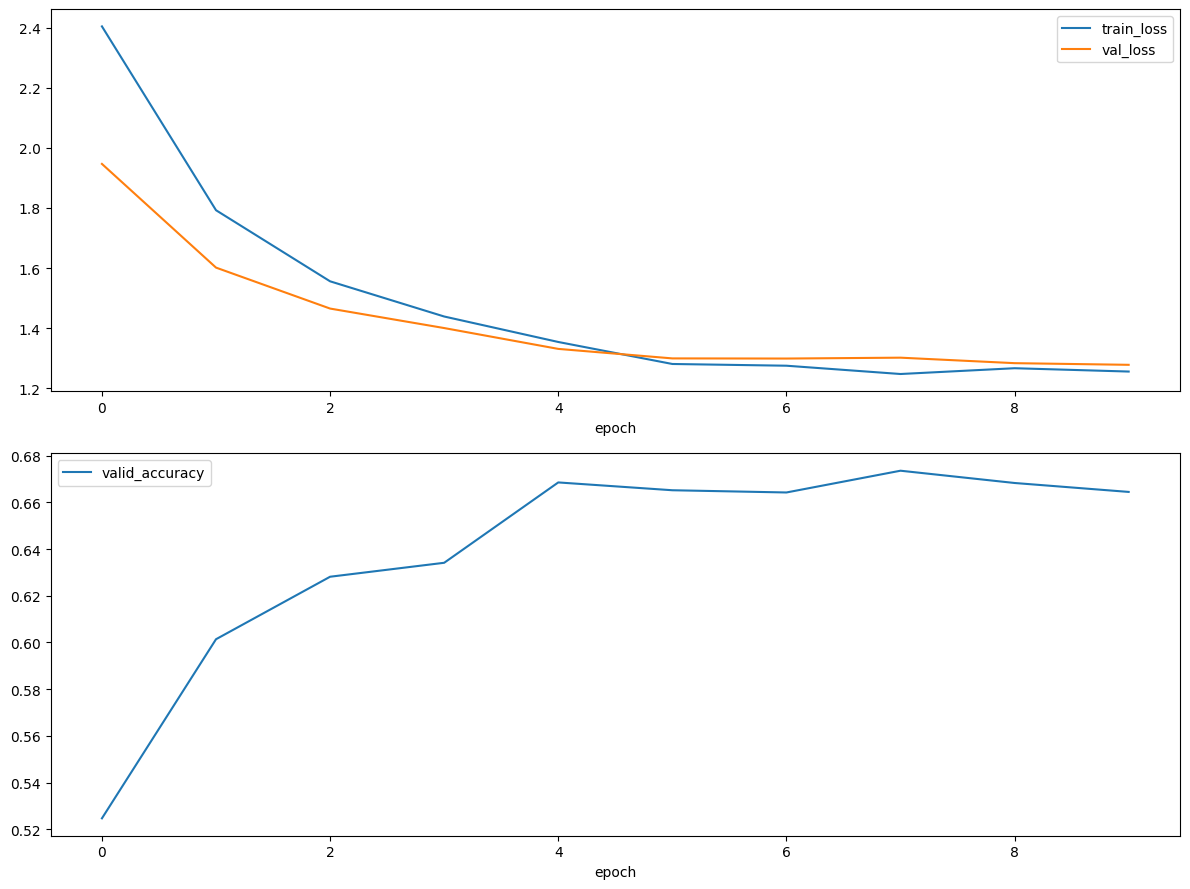

In [14]:
plot_training(*info) #0.54


In [15]:
def predict(model, test_loader):
    model.eval()
    preds = []
    
    with torch.no_grad():
        for xb, _ in test_loader:  # Игнорируем метки
            xb = xb.to(device)
            probs = model(xb)
            preds_batch = torch.argmax(probs, dim=1)
            preds.extend(preds_batch.cpu().numpy())
    
    # Получаем имена файлов из test_dataset.samples
    filenames = [Path(path).name for path, _ in test_dataset.samples]
    
    return filenames, preds

In [16]:
filenames, preds = predict(model, test_dataloader)
filtered_data = {
    "Id": [],
    "Expected": []
}

In [17]:
for filename, pred in zip(filenames, preds):
    if "-checkpoint" not in filename:  # Исключаем файлы с "-checkpoint"
        filtered_data["Id"].append(filename)
        filtered_data["Expected"].append(full_train_dataset.classes[pred])

In [18]:
results = pd.DataFrame(filtered_data)
results.to_csv("simpsons_predictions.csv", index=False)

In [19]:
results

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,charles_montgomery_burns
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum
